In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime, timedelta
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


from time import time

In [2]:
pd.read_csv('catfish.csv').head(13)

,Date,Total
0,1986-1-01,9034
1,1986-2-01,9596
2,1986-3-01,10558
3,1986-4-01,9002
4,1986-5-01,9239
5,1986-6-01,8951
6,1986-7-01,9668
7,1986-8-01,10188
8,1986-9-01,9896
9,1986-10-01,10649


In [3]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')

In [4]:
df = pd.read_csv('catfish.csv', date_parser = parser, parse_dates = [0], index_col =0)

/var/folders/vd/7kcv0wsd01qflzy6p6wd496h0000gn/T/ipykernel_86271/3042508784.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv('catfish.csv', date_parser = parser, parse_dates = [0], index_col =0)


In [5]:
df = df.asfreq(pd.infer_freq(df.index))

In [6]:
new_df = df.loc['1996-01-01':'2004-01-01']

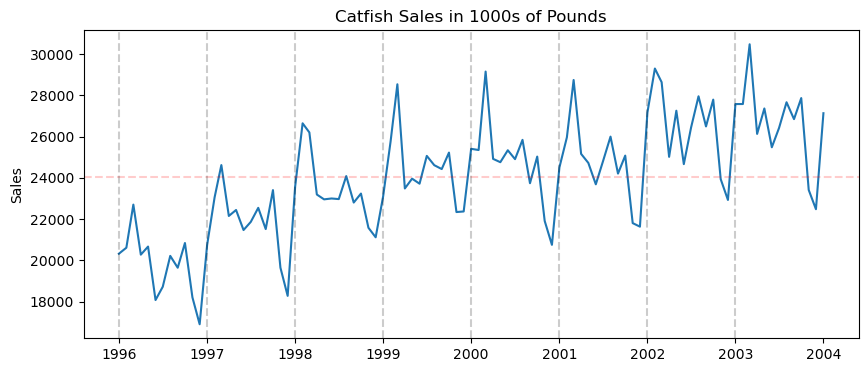

In [7]:
plt.figure(figsize = (10,4))
plt.plot(new_df)
plt.title('Catfish Sales in 1000s of Pounds')
plt.ylabel('Sales')

plt.axhline(new_df['Total'].mean(), color = 'r', linestyle = '--', alpha = 0.2)

for year in range(1996, 2004):
    plt.axvline(pd.to_datetime(str(year) + '-01-01'), color = 'k', linestyle = '--', alpha = 0.2)

** We se that the data has an upward increasing mean, which mean there is some Integrated part (I of ARIMA model), apart from that there is seasonality**

### Remove the trend

In [8]:
first_diff = new_df.diff()[1:]

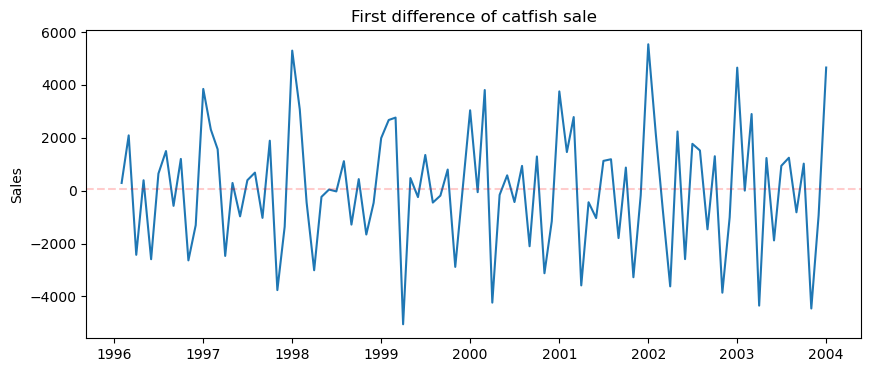

In [10]:
plt.figure(figsize = (10,4))
plt.plot(first_diff)
plt.title('First difference of catfish sale')
plt.ylabel('Sales')

plt.axhline(first_diff['Total'].mean(), color = 'r', linestyle = '--', alpha = 0.2)


## ACF and PACF

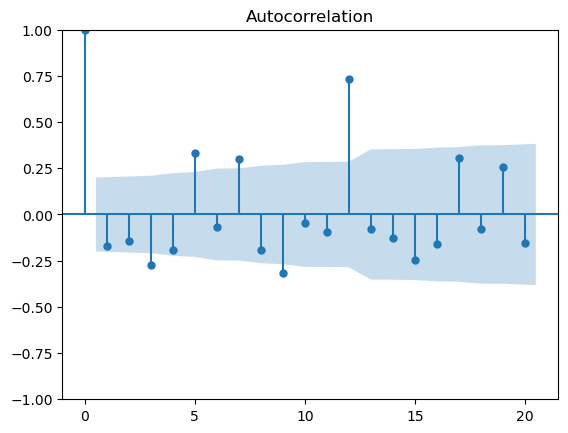

In [11]:
plot_acf = plot_acf(first_diff)

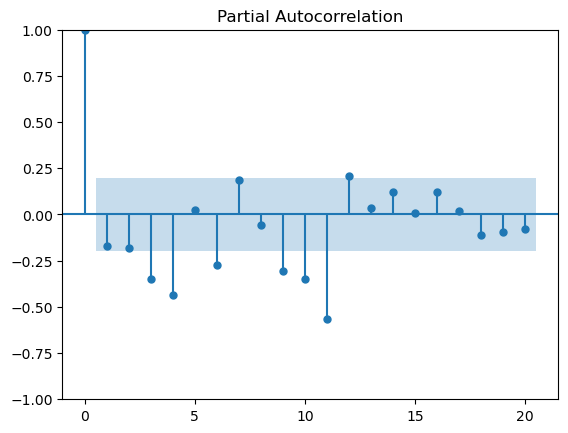

In [12]:
plot_pacf = plot_pacf(first_diff)

**Based on ACF and PACF, we see we have strong correlation at lag 12 months, and the trend is seasonal. So, we should start with seasonal MA and AR process**

## Train test data
Note: I will be using new_df for the train test data, we see that d=1 will set the dataset to stationary 

In [16]:
train_end = datetime(2003, 7, 1)
test_end = datetime(2004, 1, 1)

train_df = new_df[:train_end]
test_df = new_df[train_end + timedelta(days = 1) : test_end]

## Fit the SARIMA model

In [17]:
my_order = (0,1,0) # d=1 as the first difference was making it seasonal
my_seasonal_order = (1,0,1,12) # the last entry refers to number of point in one season. We had 12 datapoints there. p and q are 1 
# because we have seasonal AR and MA of 1

model = SARIMAX(train_df, order = my_order, seasonal_order = my_seasonal_order)

In [18]:
model_fit = model.fit()
model_fit.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.38174D+01    |proj g|=  9.15036D+00

At iterate    5    f=  8.57335D+00    |proj g|=  1.89855D-01

At iterate   10    f=  8.51714D+00    |proj g|=  3.37118D-02

At iterate   15    f=  8.51114D+00    |proj g|=  7.15279D-03

At iterate   20    f=  8.51104D+00    |proj g|=  1.08537D-04

At iterate   25    f=  8.51098D+00    |proj g|=  3.79092D-03

At iterate   30    f=  8.50475D+00    |proj g|=  2.12340D-02

At iterate   35    f=  8.50233D+00    |proj g|=  8.54165D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/Users/pragya/miniconda3/envs/hands_on_ml/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
 This problem is unconstrained.


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                Total   No. Observations:                   91
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 12)   Log Likelihood                -773.712
Date:                              Tue, 06 Aug 2024   AIC                           1553.424
Time:                                      20:18:11   BIC                           1560.924
Sample:                                  01-01-1996   HQIC                          1556.449
                                       - 07-01-2003                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.9986      0.011     88.675      0.000       0.977       1.021
ma.S.L12      -0.9557      0.183     -5.224      0.000      -1.314      -0.597
sigma2      1.257e+06   1.46e-07   8.59e+12      0.000    1.26e+06    1.26e+06
===================================================================================
Ljung-Box (L1) (Q):                  12.54   Jarque-Bera (JB):                 0.93
Prob(Q):                              0.00   Prob(JB):                         0.63
Heteroskedasticity (H):               0.80   Skew:                            -0.12
Prob(H) (two-sided):                  0.55   Kurtosis:                         2.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.21e+29. Standard errors may be unstable.
"""

In [27]:
#get the predictions and residuals

predictions = model_fit.forecast(len(test_df))
predictions = pd.Series(predictions, index = test_df.index)

residual = test_df['Total'] - predictions

Text(0, 0.5, 'Error')

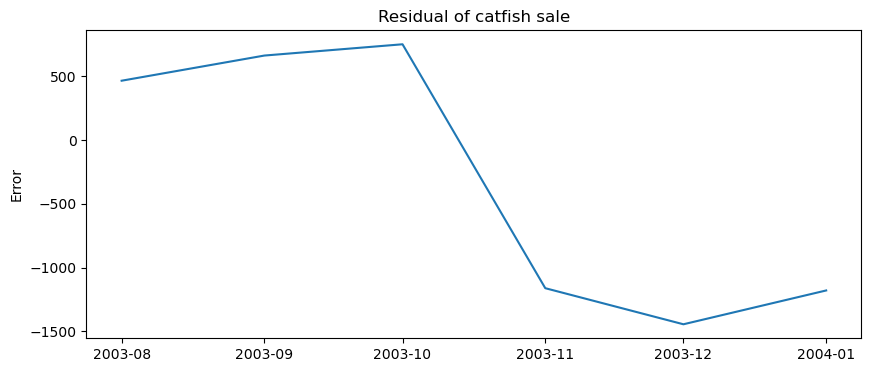

In [28]:
plt.figure(figsize = (10,4))
plt.plot(residual)
plt.title('Residual of catfish sale')
plt.ylabel('Error')


Text(0, 0.5, 'Production')

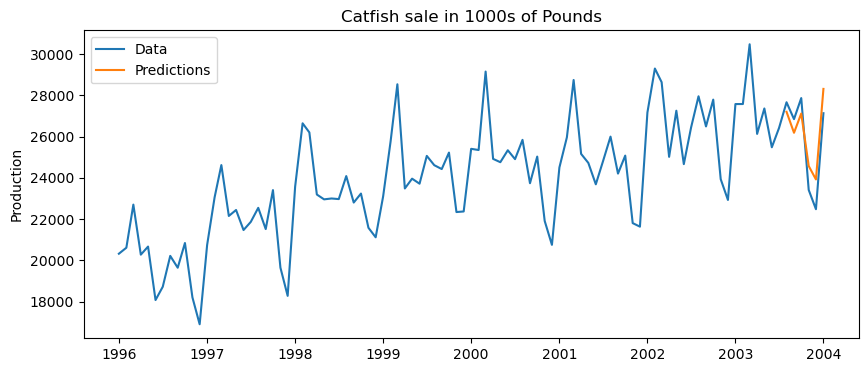

In [30]:
plt.figure(figsize = (10,4))
plt.plot(new_df)
plt.plot(predictions)
plt.legend(['Data', 'Predictions'])
plt.title('Catfish sale in 1000s of Pounds')
plt.ylabel('Production')

In [32]:
print('RMSE error : ', np.sqrt(np.mean(residual**2))) 

RMSE error :  1003.7254935738852


## Using the rolling forecast origin

In [86]:
## CREATE THE MODEL

prediction_rolling = pd.Series()

for end_date in test_df.index:

    train_df = new_df[:pd.Timestamp(end_date) - timedelta(days =  1)] # timestamp needed for arithmetic operation
    model = SARIMAX(train_data, order = my_order, seasonal_order = my_seasonal_order)
    model_fit = model.fit()

    pred = model_fit.predict(end_date)
    prediction_rolling.loc[end_date] = pred.loc[end_date]

/Users/pragya/miniconda3/envs/hands_on_ml/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
 This problem is unconstrained.
/Users/pragya/miniconda3/envs/hands_on_ml/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.32225D+01    |proj g|=  8.54996D+00

At iterate    5    f=  8.56081D+00    |proj g|=  1.51506D-01

At iterate   10    f=  8.50211D+00    |proj g|=  2.32745D-02

At iterate   15    f=  8.49765D+00    |proj g|=  3.54245D-03

At iterate   20    f=  8.49758D+00    |proj g|=  4.21997D-04

At iterate   25    f=  8.49752D+00    |proj g|=  5.56297D-03

At iterate   30    f=  8.49407D+00    |proj g|=  3.28758D-02

At iterate   35    f=  8.49007D+00    |proj g|=  6.49136D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/Users/pragya/miniconda3/envs/hands_on_ml/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
 This problem is unconstrained.
/Users/pragya/miniconda3/envs/hands_on_ml/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
 This problem is unconstrained.



At iterate   35    f=  8.49007D+00    |proj g|=  6.49136D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     35     49      1     0     0   6.491D-04   8.490D+00
  F =   8.4900731008142927     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.32225D+01    |proj g|=  8.54996D+00

At iterate    5    f=  8.56081D+00    |proj g|=  1.51506D-01

At iterate   10    f=  8.50211D+00    |proj g|=  2.32745D-02

At iter

/Users/pragya/miniconda3/envs/hands_on_ml/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
 This problem is unconstrained.
/Users/pragya/miniconda3/envs/hands_on_ml/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
 This problem is unconstrained.



At iterate   35    f=  8.49007D+00    |proj g|=  6.49136D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     35     49      1     0     0   6.491D-04   8.490D+00
  F =   8.4900731008142927     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


Text(0, 0.5, 'Error')

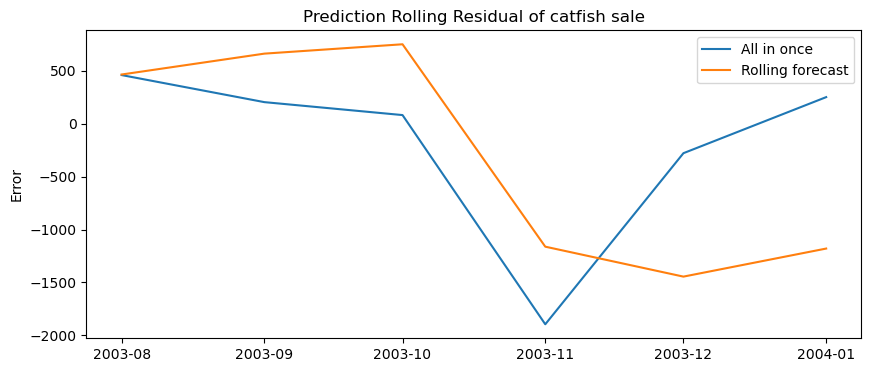

In [90]:
plt.figure(figsize = (10,4))
plt.plot(test_df['Total'] - prediction_rolling)
plt.plot(test_df['Total'] - predictions)
plt.legend(['All in once', 'Rolling forecast'])
plt.title('Prediction Rolling Residual of catfish sale')
plt.ylabel('Error')

Text(0, 0.5, 'Production')

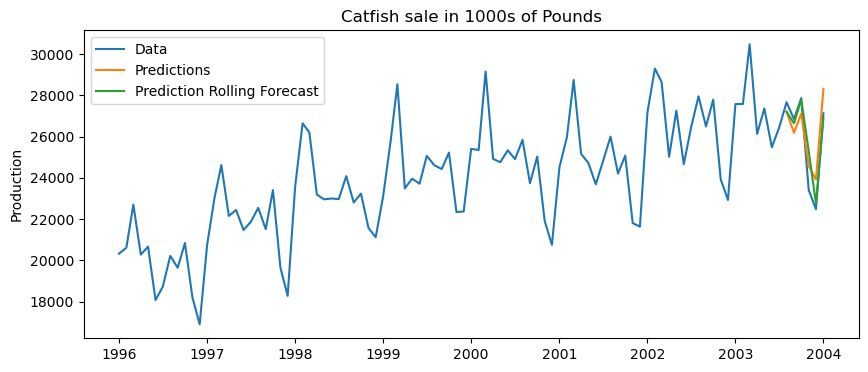

In [91]:
plt.figure(figsize = (10,4))
plt.plot(new_df)
plt.plot(predictions)
plt.plot(prediction_rolling)
plt.legend(['Data', 'Predictions', 'Prediction Rolling Forecast'])
plt.title('Catfish sale in 1000s of Pounds')
plt.ylabel('Production')

In [92]:
rolling_pred_residual = test_df['Total'] - prediction_rolling

print('RMSE error from rolling prediction: ', np.sqrt(np.mean(rolling_pred_residual ** 2)))

RMSE error from rolling prediction:  815.507343638173


**We see prediction_rolling forecast does better as it predict one datapoint in future from k datapoints, and then uses k + 1 datapoints to predict the k + 2th value. Instead of predicting all at once in future**